# Neural Pathway Prototype

This is a prototype which aims to implement the concept of neural pathways for deep neural network introspection (in this case CNN introspection). The concept originates from the paper "Deep Neural Model Inspection and Comparison via Functional Neuron Pathways" written by Fiacco, Choudhary and Rose.

The paper can be found here: <https://www.aclweb.org/anthology/P19-1575/>.  
There is also a video in which James Fiacco talks about it, found here: <https://vimeo.com/385434363>.

Note that there might be some parts where I wasn't 100% certain how they were meant to be implemented.

## Table of contents:

1. [Prerequisites](#prerequisites)  
1.1 [Imports](#imports)  
1.2 [Load dataset](#load-dataset)  
1.3 [Train model](#train-model)  
1.4 [Save model](#save-model)  
1.5 [Load model](#load-model)


2. [Neural Pathways](#neural-pathways)  
2.1 [Concept](#concept)  
2.2 [Extract activations](#extract-activations)  
2.3 [Identify Pathways](#identify-pathways)  
2.4 [Pathway Effects](#pathway-effects)  
2.5 [Associate Pathways with Task Knowledge](#associate-pathways-with-task-knowledge)  
2.6 [Rank Correlation](#rank-correlation)
2.7 [Interpretation](#interpretation)  
2.8 [Plot important pathways](#plot-important-pathways)  


3. [Adding input features to the analyzed neural pathways](#adding-input-features-to-the-analyzed-neural-pathways)  
3.1 [Identify Pathways](#identify-pathways2)  
3.2 [Pathway Effects](#pathway-effects2)  
3.3 [Associate Pathways with Task Knowledge](#associate-pathways-with-task-knowledge2)  
3.4 [Rank Correlation](#rank-correlation2)  
3.5 [Interpretation](#interpretation2)  
3.6 [Plotting](#plotting2)  


4. [Try neural pathways on input features](#try-neural-pathways-on-input-features)  
4.1 [Identify Pathways](#identify-pathways3)  
4.2 [Pathway Effects](#pathway-effects3)  
4.3 [Associate Pathways with Task Knowledge](#associate-pathways-with-task-knowledge3)  
4.4 [Rank Correlation](#rank-correlation3)  
4.5 [Interpretation](#interpretation3)  
4.6 [Plotting](#plotting3)


5. [Check importance for task knowledge](#check-importance-for-task-knowledge)  
5.1 [Extracting input features and activations](#extracting-input-features-and-activations)  
5.2 [Identify Pathways](#identify-pathways4)  
5.3 [Task Knowledge](#task-knowledge4)  
5.4 [Plotting](#plotting4)  


6. [Try with input features only](#try-with-input-features-only)  
6.1 [Extract input features](#extract-input-features5)  
6.2 [Identify Pathways](#identify-pathways5)  
6.3 [Task Knowledge](#task-knowledge5)  
6.4 [Plotting](#plotting5)

# Prerequisites<a name="prerequisites"></a>

## Imports<a name="imports"></a>

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]    # adjust width, height of plots

from math import sqrt

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from scipy.stats import spearmanr

## Load dataset:<a name="load-dataset"></a>

In [2]:
# specify dataset and load it
cifar10 = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# make pixel values range from 0 to 1 instead of 0 to 255
train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = tf.reshape(train_images, [len(train_images), 32, 32, 3])
test_images = tf.reshape(test_images, [len(test_images), 32, 32, 3])

# prepare training dataset
batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# prepare test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(batch_size)

## Train model:<a name="train-model"></a>

In [ ]:
# specify number of epochs to train
num_epochs = 50

# specify model architecture
model = keras.Sequential([
    keras.layers.Conv2D(input_shape=(32, 32, 3), data_format='channels_last', filters=16, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=3, padding='same'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=3, padding='same'),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ])

# specify used algorithms
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_function = keras.losses.SparseCategoricalCrossentropy()
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = keras.metrics.SparseCategoricalAccuracy()

for epoch in range(num_epochs):
    # iterate over batches of datataset
    for step, (image_batch_train, label_batch_train) in enumerate(train_dataset):

        with tf.GradientTape() as tape:
            logits = model(image_batch_train)
            loss_value = loss_function(label_batch_train, logits)

        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        train_acc_metric(label_batch_train, logits)

    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
    train_acc_metric.reset_states()

    # validation
    for image_batch_test, label_batch_test in test_dataset:
        test_logits = model(image_batch_test)
        test_acc_metric(label_batch_test, test_logits)
    test_acc = test_acc_metric.result()
    test_acc_metric.reset_states()
    print('Validation acc: %s\n' % (float(test_acc),))

## Save model:<a name="save-model"></a>

In [ ]:
# specify directory to save model weight and architecture files
saving_dir = '/home/users/jalemann/project/jalemann/neural_pathways/'
# make sure saving_dir specifies a directory i.e. path ends with '/'
if saving_dir[-1] is not '/':
    saving_dir += '/'

# save the weights as .h5 file
model.save_weights(saving_dir + 'model_weights.h5')

# save the model architecture as .json file
with open(saving_dir + 'model_architecture.json', 'w') as f:
    f.write(model.to_json())

## Load model:<a name="load-model"></a>

In [3]:
# specify directory to load model weights and architecture from (usually the same as saving_dir)
loading_dir = '/home/users/jalemann/project/jalemann/neural_pathways/'
# make sure loading_dir specifies a directory i.e. path ends with '/'
if loading_dir[-1] is not '/':
    loading_dir += '/'

# model reconstruction from .json file
with open(loading_dir + 'model_architecture.json', 'r') as f:
    model = tf.keras.models.model_from_json(f.read())

# load weights from .h5 file into the reconstructed model
model.load_weights(loading_dir + 'model_weights.h5')

# show summary of reconstructed model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

# Neural Pathways<a name="neural-pathways"></a>

## Concept:<a name="concept"></a>

[//]: # "Used to show the concept image of the original paper (i.e. Figure 1 of the original paper). You might need to specify the path or delete this cell if you don't need/want it."

![Concept](img/NP_Concept.png)

## Extract activations (of test set):<a name="extract-activations"></a>

**get_activations(model, img_batch):**  
Function to extract activations of a given image batch.  
Takes a model and an image batch and returns the activations. Returned activations are of shape (n_imgs, filter_size, filter_size, n_filters).

In [4]:
# ! IMPORTANT: used_layers has to be specified per model / analysis intention
# e.g. here we only look at Conv and Dense layers

# get activations for an image_batch
def get_activations(model, img_batch):
    # save output for each Conv2D and Dense layer
    used_layers = model.layers[:5:2] + model.layers[6:]  # uses every layer except flatten right now
    
    layer_outputs = [layer.output for layer in used_layers]
    
    # define a model that returns the outputs given the model input
    activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)
    
    # reshape images to arrays
    for img in img_batch:
        img = keras.preprocessing.image.img_to_array(img)
        img = tf.expand_dims(img, axis=0)

    return activation_model.predict(img_batch)

In [5]:
# get activations of the test set images
activations = get_activations(model, test_images)

In [6]:
print('Shapes of activations:')
print('Conv1: ' + str(np.shape(activations[0])))
print('Conv2: ' + str(np.shape(activations[1])))
print('Conv3: ' + str(np.shape(activations[2])))
print('Dense1: ' + str(np.shape(activations[3])))
print('Dense2: ' + str(np.shape(activations[4])))

Shapes of activations:
Conv1: (10000, 32, 32, 16)
Conv2: (10000, 11, 11, 64)
Conv3: (10000, 4, 4, 128)
Dense1: (10000, 128)
Dense2: (10000, 10)


**flatten_activations(activations, img_batch=None, is_verbose=False):**
Function to flat and concatenate activations of multiple layers.
Takes activations and returns flat_activations of shape (instances, total_num_neurons).  

Optional Parameters:  
`img_batch`: default is None, choose an image batch (e.g. test_images) to prepend their flattened input values to activations. Input values can then be used in pathways and analysis.  
`is_verbose`: boolean, default is False, if True print information about shapes of each layer and flat_activations.

In [92]:
def flatten_activations(activations, img_batch=None, is_verbose=False):
    
    if is_verbose is True:
        print('Shapes of flattened activations:')
    
    flat_activations = []
    
    if img_batch is not None:
        # prepend input values
        num_input_values = np.prod(np.shape(img_batch)[1:])
        input_features = np.transpose(img_batch, [0, 3, 2, 1]) # move channels first
        flat_activations.append(np.reshape(input_features, (np.shape(input_features)[0], num_input_values)))
        
        if is_verbose is True:
            print('Input features: ' + str(np.shape(flat_activations[0])))
    
    # iterate over layers
    for i in range(len(activations)):
        # calc total number of neurons per layer
        num_neurons = np.prod(np.shape(activations[i])[1:])
        
        # flatten activations to shape (instances, num_neurons) per layer
        # * IMPORTANT: transpose activation tensor of conv layers first, so that channel is first dimension
        if len(np.shape(activations[i])) == 4:    # if activation has shape of a conv activation
            act = np.transpose(activations[i], [0, 3, 2, 1])
            flat_activations.append(np.reshape(act, (np.shape(act)[0], num_neurons)))
            
        else:
            flat_activations.append(np.reshape(activations[i], (np.shape(activations[i])[0], num_neurons)))
        
        if is_verbose is True and img_batch is None:
            print('Layer %i: ' % (i+1) + str(np.shape(flat_activations[i])))
        elif is_verbose is True and img_batch is not None:
            print('Layer %i: ' % (i+1) + str(np.shape(flat_activations[i+1])))
            
    # concatenate each layers flattened activations to single array
    flat_activations = np.concatenate(flat_activations, axis=1)
    
    if is_verbose is True:
        print('Instances x Neurons matrix with shape ' + str(np.shape(flat_activations)))
    
    return flat_activations

In [88]:
# flatten activations
activations = flatten_activations(activations)

## Identify Pathways via PCA:<a name="identify-pathways"></a>

PCA is used to identify pathways. Number of PCA components resembles number of pathways. 

`factor_activation` resembles the activation of each pathway. Is of shape (instances, pathways).  
`factor_loadings` resembles importance of each neuron for each pathway. Is of shape (pathways, total_num_neurons).  

In [9]:
# number of PCA components resembles number of pathways
pca = PCA(n_components=100)

# activation of each pathway
factor_activation = pca.fit_transform(activations)
print('Pathway/Factor activations: ' + str(np.shape(factor_activation)))

# weight of each neuron for each pathway
factor_loadings = pca.components_
print('Factor loadings: ' + str(np.shape(factor_loadings)))

print('Explained variance ratio: ' + str(sum(pca.explained_variance_ratio_)))

Pathway/Factor activations: (10000, 100)
Factor loadings: (100, 26314)
Explained variance ratio: 0.7578012235462666


## Pathway Effects:<a name="pathway-effects"></a>

Measure pathway effects using a metric dataset.  
In our case the metric dataset is a vector that compares model predictions with ground truth for each test set instance.  
The corresponding value is 0 if our model's prediction and ground truth are the same else it's 1. In the end 1s resemble prediction errors.

In [10]:
predictions = []

# for each test set instance store class with highest predicted probability
for i in model.predict(test_images):
    label = np.where(i == np.amax(i))[0]
    predictions.append(label)
predictions = np.array(predictions)

metric_dataset = []

# compare predictions from above with ground truth, append 0 if predictions was correct, else append 1
for i in range(len(predictions)):
    if predictions[i].item() == test_labels[i].item():
        metric_dataset.append(0)
    else:
        metric_dataset.append(1)
metric_dataset = np.array(metric_dataset)

Linear Probe of each pathways activations and the metric dataset.  

`pathway_effectivity` resembles a score to what degree the pathways explain chosen metric (in our case i.e. correct/wrong predictions).  

`linear_model_1_weights` resembles the relative contribution of each pathway to our metric (in our case i.e. how much does each pathway contribute to correct/wrong predictions).

In [11]:
linear_model_1 = LogisticRegression(solver='lbfgs', max_iter=1000).fit(factor_activation, metric_dataset)

# score to what degree pathways can explain metric
pathway_effectivity = linear_model_1.score(factor_activation, metric_dataset)
print('Score: %f' % pathway_effectivity)

# relative contribution of each pathway
linear_model_1_weights = linear_model_1.coef_[0]

Score: 0.713500


In [12]:
print(np.shape(linear_model_1_weights))
print(linear_model_1_weights)

(100,)
[-2.97873876e-02 -3.17365775e-02 -2.27226734e-03 -9.30462254e-03
 -1.51899708e-02  2.03594592e-02 -3.13111418e-02  1.08380517e-02
  2.02639582e-02 -3.09409308e-02  6.86108298e-03 -2.42788488e-02
  8.50636242e-03  1.09920325e-02 -3.60077684e-02 -1.11713116e-02
 -5.95715769e-03 -2.73173041e-02 -2.12074821e-02  5.15144143e-04
  1.16484935e-03 -7.79831985e-02 -1.83368427e-02 -1.25483254e-02
  1.11570757e-02  1.74038437e-02 -1.32129696e-02  2.03980998e-02
 -2.98324035e-02 -3.56709899e-03 -3.35194001e-02 -3.92673298e-02
  5.14411934e-02  5.89232070e-03 -4.87271513e-02  2.84205682e-02
 -1.34085765e-02 -3.44322970e-03  1.39507820e-02  9.06621143e-03
  4.14171812e-02  1.86505927e-02 -2.26159540e-02  2.67200218e-02
 -8.94536263e-03  2.44213086e-02 -5.12623733e-02  3.41044749e-02
 -4.58067203e-02 -2.94391880e-02 -1.49608877e-02 -4.08557034e-02
 -1.61478845e-02  1.41349884e-02  1.18800171e-02  4.90708033e-02
  2.61321849e-02 -1.39348667e-02 -2.39901325e-02 -8.27111301e-03
  1.86807711e-02  

## Associate Pathways with Task Knowledge:<a name="associate-pathways-with-task-knowledge"></a>

To associate pathways or neurons with task knowledge we use Linear Probes again.  
We define task knowledge datasets and use them for Linear Probes with neuron or pathway activations.  

In our case we only use one task knowledge dataset which is the classification's ground truth (i.e. the label of each test set instance) because we want to find out which neurons or pathways contribute to the prediction of a certain class.

In [13]:
task_knowledge = np.reshape(test_labels, (len(test_labels),))

print(np.shape(task_knowledge))
print(np.shape(activations))

(10000,)
(10000, 26314)


Linear Probe of model activations and task knowledge.  

`linear_model_2_weights` resembles the relative contribution of each neuron to the explanation of a certain phenomenon of the external task knowledge (in our case i.e. the prediction of a certain class).  

This could also be done on a pathway level by doing the Linear Probe with `factor_activation` instead of the model activations. As far as I understand it, the approach in the paper uses the neuron level while the approach explained in the video uses the pathway level.

In [14]:
#linear_model_2 = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000).fit(factor_activation, task_knowledge)
linear_model_2 = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000, n_jobs=-2).fit(activations, task_knowledge)

# relative contribution of each pathway
linear_model_2_weights = linear_model_2.coef_

In [15]:
print(np.shape(linear_model_2_weights))
# print(linear_model_2_weights)

(10, 26314)


## Rank correlation:<a name="rank-correlation"></a>

This part is not explained in the video but described in the paper. I'm still not too certain if I understand what it is about.

In [16]:
print(np.shape(factor_loadings))
print(np.shape(linear_model_2_weights))

(100, 26314)
(10, 26314)


In [17]:
rho, _ = spearmanr(factor_loadings, linear_model_2_weights, axis=1)
print(np.shape(rho))
print(rho)

(110, 110)
[[ 1.         -0.29045195 -0.16499677 ... -0.00657111  0.03603677
   0.03450505]
 [-0.29045195  1.         -0.23166557 ...  0.00679027  0.0236243
  -0.01822593]
 [-0.16499677 -0.23166557  1.         ...  0.00194335 -0.01835329
   0.01691829]
 ...
 [-0.00657111  0.00679027  0.00194335 ...  1.         -0.05360604
  -0.04053317]
 [ 0.03603677  0.0236243  -0.01835329 ... -0.05360604  1.
  -0.11623444]
 [ 0.03450505 -0.01822593  0.01691829 ... -0.04053317 -0.11623444
   1.        ]]


## Interpretation:<a name="interpretation"></a>

**plot_activations(model, img_index, plot_input_channels):**  
Function to plot activations (feature maps) of a single input image.
Takes a model and an input image and plots the activations.  

Optional parameters:  
`plot_input_channels`: boolean, default is False, if True plots each channel of the input image.

In [102]:
# take index of a test set image and plot corresponding feature maps
def plot_activations(model, img_index, plot_input_channels=False):

    print('Original: Label = ' + label_dict[test_labels[img_index].item()])
    plt.imshow(test_images[img_index])
    plt.show()
    
    # plot single channels of input image
    if plot_input_channels is True:
        # ! modify this if input images have channels first instead of last
        n_input_channels = np.shape(test_images[img_index])[-1]

        for i in range(n_input_channels):
            inx = plt.subplot(1, n_input_channels, i+1)
            inx.set_xticks([])
            inx.set_yticks([])
            plt.imshow(test_images[img_index][:,:,i])
        plt.show()
    
    counter = 1
    
    for conv_layer in model.layers:
        # skip non conv layers
        if 'conv' not in conv_layer.name:
            continue

        sub_model = keras.Model(inputs=model.inputs, outputs=conv_layer.output)

        feature_maps = sub_model.predict(tf.expand_dims(test_images[img_index], axis=0))

        # plot all n feature maps in sqrt(n) x sqrt(n) squares
        square = int(sqrt(conv_layer.output.shape[-1]))
        ix = 1
        
        print('ConvLayer %i:' % counter)
        counter += 1
        
        # iterate over subplot square
        for _ in range(square):
            for _ in range(square):
                # specify subplot and turn of axis
                ax = plt.subplot(square, square, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel
                plt.imshow(feature_maps[0, :, :, ix-1])  # for grayscale add parameter: cmap='gray'
                ix += 1
                
        plt.show()

Original: Label = frog


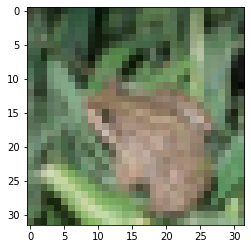

ConvLayer 1:


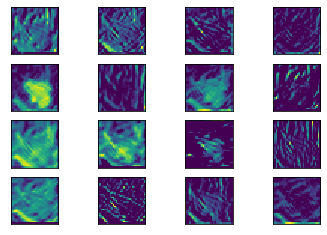

ConvLayer 2:


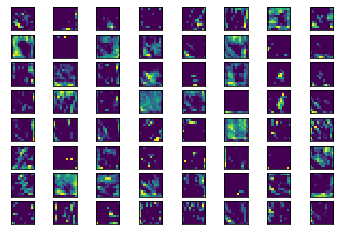

ConvLayer 3:


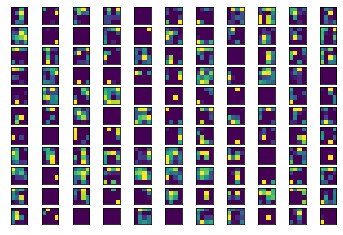

In [19]:
# specify index of test set image that is to be interpreted
interpret_index = 4

plot_activations(model, interpret_index)
label_int = test_labels[interpret_index].item()

For interpretation we want to know which pathways are most important for our metric (i.e. correct/wrong prediction). Also we might want to look at the least important pathways respectively.  

`metric_vip_list` contains most (very) important pathways regarding our chosen metric.  
`metric_nip_list` contains least (not so) important pathways regarding our chosen metric.

In [36]:
# specify the number of most/least important pathways to inspect
n_pathways = 3

# list of very/most important pathways (vip) (important regarding metric)
# ? are large valued negative weights important
abs_metric_weights = [abs(i) for i in linear_model_1_weights]
metric_vip_list = np.argpartition(abs_metric_weights, -n_pathways)[-n_pathways:]
print('Most important pathways regarding metric: ' + str(metric_vip_list))

# list of not/least important pathways (nip) (important regarding metric)
metric_nip_list = np.argpartition(abs_metric_weights, n_pathways)[:n_pathways]
print('Least important pathways regarding metric: ' + str(metric_nip_list))

# how important is each metric_vip for each class
association_dict = {}   # what class is best resembled by each vip
label_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

for vip in metric_vip_list:
    best_match_class = np.argpartition(linear_model_2_weights[:, vip], -1)[-1:].item()
    association_dict[vip] = str(best_match_class) + ' - ' + label_dict[best_match_class]

print('\nMetric-Pathway nr.: most associated class')
print(association_dict)

Most important pathways regarding metric: [64 81 97]
Least important pathways regarding metric: [90 89 19]

Metric-Pathway nr.: most associated class
{64: '6 - frog', 81: '8 - ship', 97: '4 - deer'}


# Plot important pathways:<a name="plot-important-pathways"></a>

## What's possible:
- `img_index`: integer, index of test set image to be analysed
- `pathways`: list of pathway indices
- `n_important`: integer, number of most/least important neurons (or also input values if `use_inputs=True`) to be retrieved per pathway  


- Plot single pathways on top of feature maps -> `plot_featmaps=True`
- plot single pathway masks only -> `plot_featmaps=False`  


- plot multiple pathways as averaged mask -> `average_pathways=True`  


- plot most important pathways -> `pathways=metric_vip_list`
- plot least important pathways -> `pathways=metric_nip_list`)  


- Analyse parts of input -> `use_inputs=True`
    - requires activations with prepended input values (is used later on in the notebook)

In [210]:
# plot activations with highlighted pathway
def plot_pathways(img_index, pathways, n_important, plot_featmaps=True, average_pathways=False, use_inputs=False):
    
    # enable interactive mode of pyplot
    plt.ion()
    
    # show original image from test set and print it's ground truth
    print('Original: Label = ' + label_dict[test_labels[img_index].item()])
    plt.imshow(test_images[img_index])
    plt.show()
    
    # create mask with same shape as input images: (32, 32, 3)
    if use_inputs is True:
        input_mask = np.zeros((32, 32, 3))
        
        # ! modify this if input images have channels first instead of last
        n_input_channels = np.shape(test_images[img_index])[-1]
        
        # plot channels of input image
        for channel in range(n_input_channels):
            inx = plt.subplot(1, n_input_channels, channel+1)
            inx.set_xticks([])
            inx.set_yticks([])
            plt.imshow(test_images[img_index][:,:,channel])
    
    # if average_pathways=False plot each pathway individually
    if average_pathways is False:
        
        # get important neurons of each very important pathway 
        for pathway in pathways:
            important_neurons = np.argpartition(factor_loadings[pathway], -n_important)[-n_important:]
            
            if use_inputs is True:
                for index in important_neurons:
                    if index < 3072:
                        input_mask[np.unravel_index(index, (32, 32, 3))] = 1

                # plot mask for input channels
                for channel in range(n_input_channels):
                    inx = plt.subplot(1, n_input_channels, channel+1)
                    inx.set_xticks([])
                    inx.set_yticks([])
                    plt.imshow(input_mask[:,:,channel], alpha=0.5, cmap='plasma')
                plt.show()
            
            # layer counter
            layer_counter = 1

            for conv_layer in model.layers:
                # skip non conv layers
                if 'conv' not in conv_layer.name:
                    continue

                # plot all n feature maps in sqrt(n) x sqrt(n) squares
                square = int(sqrt(conv_layer.output.shape[-1]))

                if plot_featmaps is True:
                    sub_model = keras.Model(inputs=model.inputs, outputs=conv_layer.output)

                    feature_maps = sub_model.predict(tf.expand_dims(test_images[img_index], axis=0))

                    ix = 1

                    print('ConvLayer %i:' % layer_counter) 

                    # plot filters
                    for _ in range(square):
                        for _ in range(square):
                            # specify subplot and turn of axis
                            ax = plt.subplot(square, square, ix)
                            ax.set_xticks([])
                            ax.set_yticks([])
                            # plot filter channel
                            plt.imshow(feature_maps[0, :, :, ix-1])  # for grayscale add parameter: cmap='gray'
                            ix += 1

                # plot pathway mask
                ix = 1

                # create masks with same shape as feature maps
                if layer_counter == 1:
                    masks = np.zeros((1, 32, 32, 16))

                elif layer_counter == 2:
                    masks = np.zeros((1, 11, 11, 64))

                elif layer_counter == 3:
                    masks = np.zeros((1, 4, 4, 128))

                    if use_inputs is False:
                        # set values on important spots to 1
                        for index in important_neurons:
                            if index < 16384 and layer_counter == 1:
                                masks[(0,) + np.unravel_index(index, (32, 32, 16))] = 1

                            elif index > 16383 and index < 24128 and layer_counter == 2:
                                masks[(0,) + np.unravel_index(index-16384, (11, 11, 64))] = 1

                            elif index > 24128 and index < 26176 and layer_counter == 3:
                                masks[(0,) + np.unravel_index(index-24129, (4, 4, 128))] = 1
                                
                    elif use_inputs is True:
                        # set values on important spots to 1
                        for index in important_neurons:
                            if index > 3071 and index < 19456 and layer_counter == 1:
                                masks[(0,) + np.unravel_index(index-3072, (32, 32, 16))] = 1

                            elif index > 19455 and index < 27200 and layer_counter == 2:
                                masks[(0,) + np.unravel_index(index-19456, (11, 11, 64))] = 1

                            elif index > 27199 and index < 29248 and layer_counter == 3:
                                masks[(0,) + np.unravel_index(index-27200, (4, 4, 128))] = 1

                layer_counter += 1
                
                for _ in range(square):
                    for _ in range(square):
                        # specify subplot and turn of axis
                        ax = plt.subplot(square, square, ix)
                        ax.set_xticks([])
                        ax.set_yticks([])
                        plt.imshow(masks[0, :, :, ix-1], alpha=0.5, cmap='plasma')
                        ix += 1
                plt.show()
                
    # build average mask for all pathways
    elif average_pathways is True:
        
        if use_inputs is True:
            # get important neurons of pathways
            for pathway in pathways:
                neuron_weights = factor_loadings[pathway]
                important_neurons = np.argpartition(neuron_weights, -1000)[-1000:]

                for index in important_neurons:
                    if index < 3072:
                        input_mask[np.unravel_index(index, (32, 32, 3))] += 1/n_pathways

                # plot mask for input channels
                for channel in range(n_input_channels):
                    inx = plt.subplot(1, n_input_channels, channel+1)
                    inx.set_xticks([])
                    inx.set_yticks([])
                    plt.imshow(input_mask[:,:,channel], alpha=0.5, cmap='plasma')
            plt.show()

            layer_counter = 1

        for conv_layer in model.layers:
            # skip non conv layers
            if 'conv' not in conv_layer.name:
                continue

            # plot all n feature maps in sqrt(n) x sqrt(n) squares
            square = int(sqrt(conv_layer.output.shape[-1]))

            if plot_featmaps is True:
                sub_model = keras.Model(inputs=model.inputs, outputs=conv_layer.output)

                feature_maps = sub_model.predict(tf.expand_dims(test_images[img_index], axis=0))

                ix = 1

                print('ConvLayer %i:' % layer_counter) 

                # plot filters
                for _ in range(square):
                    for _ in range(square):
                        # specify subplot and turn of axis
                        ax = plt.subplot(square, square, ix)
                        ax.set_xticks([])
                        ax.set_yticks([])
                        # plot filter channel
                        plt.imshow(feature_maps[0, :, :, ix-1])  # for grayscale add parameter: cmap='gray'
                        ix += 1

            # plot pathway mask
            ix = 1

            # create masks with same shape as feature maps
            if layer_counter == 1:
                masks = np.zeros((1, 32, 32, 16))

            elif layer_counter == 2:
                masks = np.zeros((1, 11, 11, 64))

            elif layer_counter == 3:
                masks = np.zeros((1, 4, 4, 128))

            # get important neurons of vips
            for pathway in pathways:
                neuron_weights = factor_loadings[pathway]
                important_neurons = np.argpartition(neuron_weights, -1000)[-1000:]

                if use_inputs is False:
                    for index in important_neurons:
                        if index < 16384 and layer_counter == 1:
                            masks[(0,) + np.unravel_index(index, (32, 32, 16))] += 1/n_pathways

                        elif index > 16383 and index < 24128 and layer_counter == 2:
                            masks[(0,) + np.unravel_index(index-16384, (11, 11, 64))] += 1/n_pathways

                        elif index > 24128 and index < 26176 and layer_counter == 3:
                            masks[(0,) + np.unravel_index(index-24129, (4, 4, 128))] += 1/n_pathways

                elif use_inputs is True:
                    for index in important_neurons:
                        if index > 3071 and index < 19456 and layer_counter == 1:
                            masks[(0,) + np.unravel_index(index-3072, (32, 32, 16))] += 1/n_pathways

                        elif index > 19455 and index < 27200 and layer_counter == 2:
                            masks[(0,) + np.unravel_index(index-19456, (11, 11, 64))] += 1/n_pathways

                        elif index > 27199 and index < 29248 and layer_counter == 3:
                            masks[(0,) + np.unravel_index(index-27200, (4, 4, 128))] += 1/n_pathways
                    
            layer_counter += 1
            
            for _ in range(square):
                for _ in range(square):
                    # specify subplot and turn of axis
                    ax = plt.subplot(square, square, ix)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    plt.imshow(masks[0, :, :, ix-1], alpha=0.5, cmap='plasma')
                    ix += 1
                    
            plt.show()

Original: Label = frog


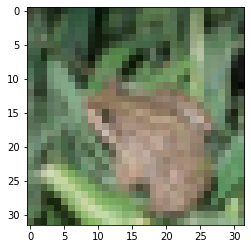

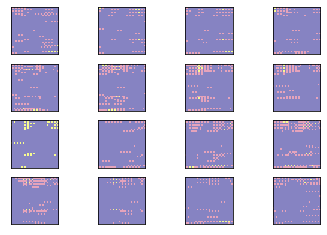

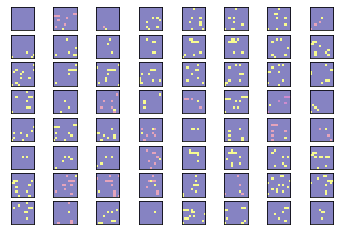

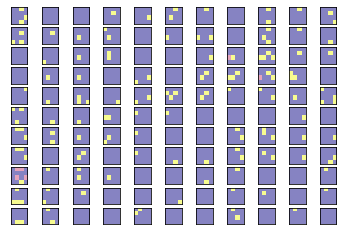

In [143]:
plot_pathways(img_index=4, pathways=metric_vip_list, n_important=2000, plot_featmaps=False, average_pathways=True)

# Adding input features to the analyzed neural pathways:<a name="adding-input-features-to-the-analyzed-neural-pathways"></a>

We figured it might be interesting to not only visualize important parts of activations but also parts of the original input.  

To do so, we prepend the input values to the activations. Then we repeat the neural pathway analysis we have done before.  
The pathways we get via PCA then can contain parts of the input images and we can try to measure their importance on a metric (i.e. correct/wrong classification in our case).

We can extract the activations as we did before.

In [93]:
# get activations of the test set images
activations = get_activations(model, test_images)

We choose the test set images as `img_batch` for the `flatten_activations` function.  
This prepends all input features of each test set image to our activations.

In [ ]:
"""
# each layer's number of neurons
input_features: x-axis indices 0 to 3071   # 3072 elements
neurons_l1: x-axis indices 3072 to 19455   # 19456 elements
neurons_l2: x-axis indices 19456 to 27199  # 27200 elements
neurons_l3: x-axis indices 27200 to 29247  # 29248 elements
neurons_l4: x-axis indices 29248 to 29375  # 29376 elements
neurons_l5: x-axis indices 29376 to 29385  # 29386 elements
"""

In [94]:
input_activations = flatten_activations(activations, img_batch=test_images, is_verbose=True)

Shapes of flattened activations:
Input features: (10000, 3072)
Layer 1: (10000, 16384)
Layer 2: (10000, 7744)
Layer 3: (10000, 2048)
Layer 4: (10000, 128)
Layer 5: (10000, 10)
Instances x Neurons matrix with shape (10000, 29386)


## Identify Pathways via PCA:<a name="identify-pathways2"></a>

The way to identify pathways is the same as before.  
We apply PCA to the `input_activations` now instead of just to the activations.

In [95]:
# number of PCA componants resembles number of pathways
pca = PCA(n_components=100)

# activation of each pathway
factor_activation = pca.fit_transform(input_activations)
print('Pathway/Factor activations: ' + str(np.shape(factor_activation)))

# weight of each input value or neuron for each pathway
factor_loadings = pca.components_
print('Factor loadings: ' + str(np.shape(factor_loadings)))

print('Explained variance ratio: ' + str(sum(pca.explained_variance_ratio_)))

Pathway/Factor activations: (10000, 100)
Factor loadings: (100, 29386)
Explained variance ratio: 0.779905112227295


## Pathway Effects:<a name="pathway-effects2"></a>

(This step did not change, it is the same as before.)  

Measure pathway effects using a metric dataset.  
In our case the metric dataset is a vector that compares model predictions with ground truth for each test set instance.  
The corresponding value is 0 if our model's prediction and ground truth are the same else it's 1. In the end 1s resemble prediction errors.

In [74]:
predictions = []

# for each test set instance store class with highest predicted probability
for i in model.predict(test_images):
    label = np.where(i == np.amax(i))[0]
    predictions.append(label)
predictions = np.array(predictions)

metric_dataset = []

# compare predictions from above with ground truth, append 0 if predictions was correct, else append 1
for i in range(len(predictions)):
    if predictions[i].item() == test_labels[i].item():
        metric_dataset.append(0)
    else:
        metric_dataset.append(1)
metric_dataset = np.array(metric_dataset)

Linear Probe of each pathways activations and the metric dataset.  

`pathway_effectivity` resembles a score to what degree the pathways explain chosen metric (in our case i.e. correct/wrong predictions).  

`linear_model_1_weights` resembles the relative contribution of each pathway to our metric (in our case i.e. how much does each pathway contribute to correct/wrong predictions).

In [97]:
linear_model_1 = LogisticRegression(solver='lbfgs', max_iter=1000).fit(factor_activation, metric_dataset)

# score to what degree pathways can explain metric
pathway_effectivity = linear_model_1.score(factor_activation, metric_dataset)
print('Score: %f' % pathway_effectivity)

# relative contribution of each pathway
linear_model_1_weights = linear_model_1.coef_[0]

Score: 0.713000


In [76]:
print(np.shape(linear_model_1_weights))
print(linear_model_1_weights)

(100,)
[-0.01932941  0.02933346  0.00341285 -0.02458184  0.01454395  0.02020037
 -0.00454076 -0.01840343  0.03211618 -0.00663414  0.00111334  0.03179527
  0.02127338  0.02227204  0.00056554  0.01037054  0.01260736 -0.02769433
  0.00853824 -0.01356988  0.00026116  0.00835888 -0.02045478 -0.02633801
  0.02983204  0.01973386 -0.02550916  0.04393467 -0.0110837  -0.03511708
 -0.03285772  0.02631581 -0.03710401  0.05591699  0.00994932 -0.00199515
  0.03295581  0.02267514  0.04203315  0.02001406  0.02024781 -0.00157336
  0.00662498  0.00697369  0.03347183 -0.00540078 -0.02366717  0.01382168
  0.00322316  0.01936197  0.01667571 -0.01486967  0.00556345 -0.03678146
  0.00917484 -0.0475204  -0.05811433  0.00499235  0.01066847 -0.03153681
  0.00624073 -0.0144424   0.01448182  0.00298463  0.04273019  0.06410726
  0.01065207  0.01578521 -0.00802168 -0.04009261  0.05427797  0.00260807
 -0.04128042  0.01284487 -0.01472391 -0.01394077  0.02143046 -0.01030357
  0.0554859   0.00489752 -0.05436051  0.0115

## Associate Pathways with Task Knowledge:<a name="associate-pathways-with-task-knowledge2"></a>

(This step did not change, it is the same as before.)  

To associate pathways or neurons with task knowledge we use Linear Probes again.  
We define task knowledge datasets and use them for Linear Probes with neuron or pathway activations.  

In our case we only use one task knowledge dataset which is the classification's ground truth (i.e. the label of each test set instance) because we want to find out which neurons or pathways contribute to the prediction of a certain class.

In [77]:
task_knowledge = np.reshape(test_labels, (len(test_labels),))

print(np.shape(task_knowledge))
print(np.shape(input_activations))

(10000,)
(10000, 29386)


Linear Probe of model activations and task knowledge.  

`linear_model_2_weights` resembles the relative contribution of each neuron to the explanation of a certain phenomenon of the external task knowledge (in our case i.e. the prediction of a certain class).  

This could also be done on a pathway level by doing the Linear Probe with `factor_activation` instead of the model activations. As far as I understand it, the approach in the paper uses the neuron level while the approach explained in the video uses the pathway level.

In [78]:
linear_model_2 = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000).fit(input_activations, task_knowledge)

# relative contribution of each pathway
linear_model_2_weights = linear_model_2.coef_

The weights represent how important each neuron is to explain a certain phenomenon of the external task knowledge.

In this case how important a certain pathway is for the detection of a certain class.

In [79]:
print(np.shape(linear_model_2_weights))
print(linear_model_2_weights)

(10, 29386)
[[ 0.01705899  0.07659949  0.1212702  ... -0.12230156 -0.17839167
   0.00699766]
 [-0.04102196 -0.08658276 -0.09186649 ...  0.03624864 -0.14802906
  -0.23965329]
 [ 0.07390361  0.06342726  0.01108558 ... -0.21570081 -0.10831445
   0.09693925]
 ...
 [-0.03391756 -0.0246069   0.06657948 ...  0.67516688 -0.22358272
  -0.20376527]
 [ 0.05524077  0.02097159  0.08518726 ... -0.01782151  0.66669362
  -0.22840197]
 [ 0.02889339  0.01664114  0.01993092 ... -0.02452006 -0.17755533
   0.79182178]]


## Rank Correlation:<a name="rank-correlation2"></a>

(This step did not change, it is the same as before.)

In [80]:
print(np.shape(factor_loadings))
print(np.shape(linear_model_2_weights))

(100, 29386)
(10, 29386)


In [81]:
rho, _ = spearmanr(factor_loadings, linear_model_2_weights, axis=1)
print(np.shape(rho))
print(rho)

(110, 110)
[[ 1.00000000e+00  7.27032415e-03 -1.95303626e-01 ... -1.63912988e-03
   2.45297844e-02  3.35780336e-02]
 [ 7.27032415e-03  1.00000000e+00  1.48353105e-01 ... -5.89291867e-03
  -3.25852302e-02 -1.03944587e-02]
 [-1.95303626e-01  1.48353105e-01  1.00000000e+00 ... -1.79283448e-04
  -2.35324314e-02  7.22041145e-03]
 ...
 [-1.63912988e-03 -5.89291867e-03 -1.79283448e-04 ...  1.00000000e+00
  -5.23936788e-02 -3.73311704e-02]
 [ 2.45297844e-02 -3.25852302e-02 -2.35324314e-02 ... -5.23936788e-02
   1.00000000e+00 -1.16514804e-01]
 [ 3.35780336e-02 -1.03944587e-02  7.22041145e-03 ... -3.73311704e-02
  -1.16514804e-01  1.00000000e+00]]


## Interpretation:<a name="interpretation2"></a>

To plot the activations as well as each channel of the input image, we want to set the optional parameter `plot_input_channels` of the function `plot_activations` to True.

Original: Label = frog


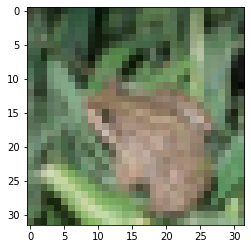

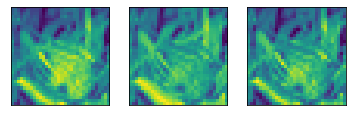

ConvLayer 1:


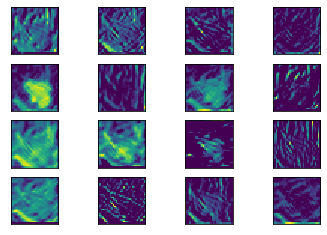

ConvLayer 2:


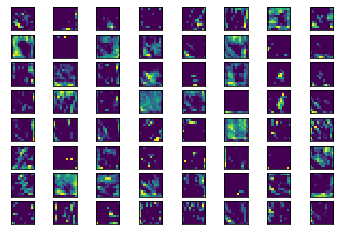

ConvLayer 3:


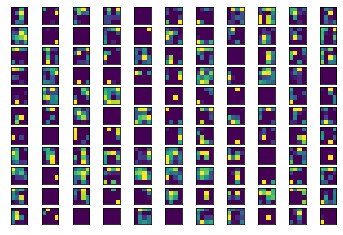

In [114]:
# choose index for test set
interpretation_index = 4

plot_activations(model, interpretation_index, plot_input_channels=True)
label_int = test_labels[interpretation_index].item()

For interpretation we want to know which pathways are most important for our metric (i.e. correct/wrong prediction). Also we might want to look at the least important pathways respectively.  

`metric_vip_list` contains most (very) important pathways regarding our chosen metric.  
`metric_nip_list` contains least (not so) important pathways regarding our chosen metric.

In [108]:
# specify the number of most/least important pathways to inspect
n_pathways = 3

# list of very/most important pathways (vip) (important regarding metric)
# ? are large valued negative weights important
abs_metric_weights = [abs(i) for i in linear_model_1_weights]
metric_vip_list = np.argpartition(abs_metric_weights, -n_pathways)[-n_pathways:]
print('Most important pathways regarding metric: ' + str(metric_vip_list))

# list of not/least important pathways (nip) (important regarding metric)
metric_nip_list = np.argpartition(abs_metric_weights, n_pathways)[:n_pathways]
print('Least important pathways regarding metric: ' + str(metric_nip_list))

# how important is each metric_vip for each class
association_dict = {}   # what class is best resembled by each vip
label_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

for vip in metric_vip_list:
    best_match_class = np.argpartition(linear_model_2_weights[:, vip], -1)[-1:].item()
    association_dict[vip] = str(best_match_class) + ' - ' + label_dict[best_match_class]

print('\nMetric-Pathway nr.: most associated class')
print(association_dict)

Most important pathways regarding metric: [83 65 92]
Least important pathways regarding metric: [20 14 71]

Metric-Pathway nr.: most associated class
{83: '3 - cat', 65: '8 - ship', 92: '5 - dog'}


## Plotting:<a name="plotting2"></a>

We use the `plot_pathways` again.  
Because we prepended the input features to the activations that we then used to find pathways via PCA, we can now set the parameter `use_inputs=True` to also plot the input channels and their important pathway parts.

Original: Label = frog


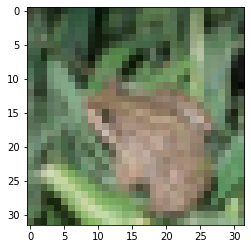

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


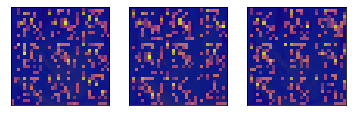

ConvLayer 1:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:222: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


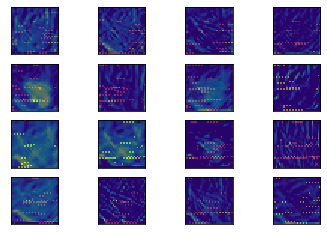

ConvLayer 2:


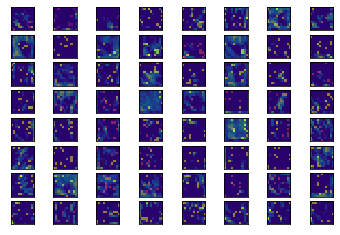

ConvLayer 3:


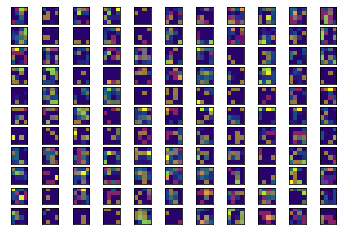

In [161]:
plot_pathways(interpretation_index, pathways=metric_vip_list, n_important=2000, plot_featmaps=True, average_pathways=True, use_inputs=True)

# Try neural pathways on input features:<a name="try-neural-pathways-on-input-features"></a>

We might find pathways in input features more interesting than pathways in neurons.  
The following code will repeat the analysis for input values only. This is done by skipping the extraction of activations and only passing the input features to PCA.

In [162]:
def get_input_features(img_batch):

    # each layer's number of neurons
    input_features = np.prod(np.shape(img_batch)[1:])  # x-axis indices 0 to 3071       # 3072 elements

    # reshape to shape (instances, neurons), transpose n_channels to first index
    input_l = np.transpose(img_batch, [0, 3, 1, 2])
    input_l = np.reshape(img_batch, (10000, input_features))

    print('Shapes of flattened activations:')
    print('Input: ' + str(np.shape(input_l)))
    print()
    
    input_features = input_l

    print('Instances x Neurons matrix with shape ' + str(np.shape(input_features)))
    
    return input_features

In [163]:
input_features = get_input_features(test_images)

Shapes of flattened activations:
Input: (10000, 3072)

Instances x Neurons matrix with shape (10000, 3072)


## Identify Pathways via PCA:<a name="identify-pathways3"></a>

In [164]:
pca = PCA(n_components=100)

factor_activation = pca.fit_transform(input_features)
print('Pathway/Factor activations: ' + str(np.shape(factor_activation)))

factor_loadings = pca.components_
print('Factor loadings: ' + str(np.shape(factor_loadings)))

print('Explained variance ratio: ' + str(sum(pca.explained_variance_ratio_)))

Pathway/Factor activations: (10000, 100)
Factor loadings: (100, 3072)
Explained variance ratio: 0.9022239859162685


## Pathway Effects:<a name="pathway-effects3"></a>

In [165]:
predictions = []

# for each test set instance store class with highest predicted probability
for i in model.predict(test_images):
    label = np.where(i == np.amax(i))[0]
    predictions.append(label)
predictions = np.array(predictions)

metric_dataset = []

# compare predictions from above with ground truth, append 0 if predictions was correct, else append 1
for i in range(len(predictions)):
    if predictions[i].item() == test_labels[i].item():
        metric_dataset.append(0)
    else:
        metric_dataset.append(1)
metric_dataset = np.array(metric_dataset)

In [166]:
linear_model_1 = LogisticRegression(solver='lbfgs', max_iter=1000).fit(factor_activation, metric_dataset)

# score to what degree pathways can explain metric
pathway_effectivity = linear_model_1.score(factor_activation, metric_dataset)
print('Score: %f' % pathway_effectivity)

# relative contribution of each pathway
linear_model_1_weights = linear_model_1.coef_[0]

Score: 0.713900


In [167]:
print(np.shape(linear_model_1_weights))
print(linear_model_1_weights)

(100,)
[-0.01916296  0.01880254 -0.02876045 -0.03547382  0.04147542  0.01322376
 -0.01349971 -0.0027185  -0.04552374  0.0039311   0.00451399  0.01253264
  0.02385602  0.00756111  0.0153887   0.03971506  0.00325845 -0.04345928
 -0.06010576 -0.03604752  0.07115207  0.03882069 -0.05755662 -0.01158944
  0.0437025  -0.00138662 -0.01754209 -0.05791243  0.03981346  0.01528241
  0.00768958  0.01907942 -0.04286426  0.02474732  0.00687453  0.03792133
  0.01628228 -0.03010313  0.06444596 -0.0114557  -0.03396322 -0.05099131
  0.01133656 -0.05153197  0.03607761  0.04836352  0.01820232 -0.07093865
  0.02597654  0.0043848   0.00082276  0.03419318 -0.05586157 -0.05812081
 -0.10805083 -0.05101478  0.10754561 -0.04048592 -0.01853004 -0.08273555
  0.00964174 -0.02709052  0.03070382  0.0074581   0.06862582  0.00404235
 -0.08825382 -0.08934746 -0.00732382 -0.01436007 -0.01872301  0.04971141
  0.00123357 -0.046938    0.01614349  0.04304857  0.07017234 -0.01265172
 -0.06663081  0.02026384 -0.04072382  0.0410

## Associate Pathways with Task Knowledge:<a name="associate-pathways-with-task-knowledge3"></a>

In [168]:
task_knowledge = np.reshape(test_labels, (len(test_labels),))

print(np.shape(task_knowledge))
print(np.shape(input_features))

(10000,)
(10000, 3072)


In [169]:
linear_model_2 = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000).fit(input_features, task_knowledge)

# relative contribution of each pathway
linear_model_2_weights = linear_model_2.coef_

The weights represent how important each neuron is to explain a certain phenomenon of the external task knowledge.

In this case how important a certain pathway is for the detection of a certain class.

In [170]:
print(np.shape(linear_model_2_weights))
print(linear_model_2_weights)

(10, 3072)
[[-0.12606778  0.75033234  0.81967814 ... -0.28941559  0.19084605
  -0.54817887]
 [ 0.09407981 -0.19863476  0.2058702  ... -0.07764907 -0.36224037
   0.04661089]
 [ 0.09289275 -0.00678351 -0.27996907 ...  0.26853259  0.33366925
  -0.18797177]
 ...
 [-0.09042179 -0.17702924  0.27340477 ... -0.00386661  0.196466
  -0.46084859]
 [-0.05414001 -0.02518763  0.87133779 ... -0.35959148  0.21173181
   0.83955455]
 [ 0.1564421   0.17609809  0.62766193 ...  0.48866842  0.07439081
  -0.2102106 ]]


## Rank Correlation:<a name="rank-correlation3"></a>

In [171]:
print(np.shape(factor_loadings))
print(np.shape(linear_model_2_weights))

(100, 3072)
(10, 3072)


In [172]:
rho, _ = spearmanr(factor_loadings, linear_model_2_weights, axis=1)
print(np.shape(rho))
print(rho)

(110, 110)
[[ 1.         -0.66492477 -0.54978183 ... -0.00358143  0.00405697
   0.01871284]
 [-0.66492477  1.         -0.08308709 ...  0.00209169 -0.01256269
  -0.01808838]
 [-0.54978183 -0.08308709  1.         ... -0.00210741  0.01584971
  -0.01062784]
 ...
 [-0.00358143  0.00209169 -0.00210741 ...  1.         -0.05869497
  -0.12597229]
 [ 0.00405697 -0.01256269  0.01584971 ... -0.05869497  1.
  -0.0932477 ]
 [ 0.01871284 -0.01808838 -0.01062784 ... -0.12597229 -0.0932477
   1.        ]]


## Interpretation:<a name="interpretation3"></a>

In [174]:
# specify the number of most/least important pathways to inspect
n_pathways = 3

# list of very/most important pathways (vip) (important regarding metric)
# ? are large valued negative weights important
abs_metric_weights = [abs(i) for i in linear_model_1_weights]
metric_vip_list = np.argpartition(abs_metric_weights, -n_pathways)[-n_pathways:]
print('Most important pathways regarding metric: ' + str(metric_vip_list))

# list of not/least important pathways (nip) (important regarding metric)
metric_nip_list = np.argpartition(abs_metric_weights, n_pathways)[:n_pathways]
print('Least important pathways regarding metric: ' + str(metric_nip_list))

# how important is each metric_vip for each class
association_dict = {}   # what class is best resembled by each vip
label_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

for vip in metric_vip_list:
    best_match_class = np.argpartition(linear_model_2_weights[:, vip], -1)[-1:].item()
    association_dict[vip] = str(best_match_class) + ' - ' + label_dict[best_match_class]

print('\nMetric-Pathway nr.: most associated class')
print(association_dict)

Most important pathways regarding metric: [86 56 54]
Least important pathways regarding metric: [50 72 25]

Metric-Pathway nr.: most associated class
{86: '3 - cat', 56: '9 - truck', 54: '4 - deer'}


## Plotting:<a name="plotting3"></a>

In [181]:
# plot input channels with pathways:
def plot_avg_input_pathways(img_index, pathways, n_important):
    
    # create mask with same shape as input images: (32, 32, 3)
    input_mask = np.zeros((32, 32, 3))
    
    # plot channels of input image
    for i in range(3):
        inx = plt.subplot(1, 3, i+1)
        inx.set_xticks([])
        inx.set_yticks([])
        plt.imshow(test_images[img_index][:,:,i])
    
    # get important neurons of vips
    for pathway in pathways:
        neuron_weights = factor_loadings[pathway]
        important_neurons = np.argpartition(neuron_weights, -n_important)[-n_important:]

        for index in important_neurons:
            if index < 3072:
                input_mask[np.unravel_index(index, (32, 32, 3))] += 1/n_important
    
    # plot mask for input channels
    n_input_channels = np.shape(test_images[img_index])[-1]
    
    for channel in range(n_input_channels):
        inx = plt.subplot(1, n_input_channels, channel+1)
        inx.set_xticks([])
        inx.set_yticks([])
        plt.imshow(input_mask[:,:,channel], alpha=0.5)
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


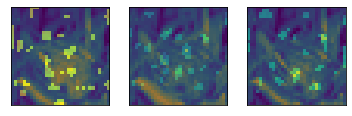

In [182]:
plot_avg_input_pathways(img_index=interpret_index, pathways=metric_vip_list, n_important=100)

# Check importance for task knowledge instead of importance for chosen metric:<a name="check-importance-for-task-knowledge"></a>

If everything worked as we thought it would, we saw parts of input images and parts of our model that are of high importance for the chosen metric. I.e. the correct/wrong classification of input images.  
So parts highlighted by masks were often either the cause for a successful classification or the cause for errors.  

We think that it would be more intuitively understandable to highlight spots that are important for the detection of a certain class. E.g. the tires of a truck or automobile because animals, ships and planes don't have them.

**Note:** We can reuse some code from above.  
I will copy it down here so one can start running the code from here and is not required to run something above.

In [183]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]    # adjust width, height of plots

from math import sqrt

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from scipy.stats import spearmanr

In [184]:
cifar10 = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# make pixel values 0 to 1 instead of 0 to 255
train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = tf.reshape(train_images, [len(train_images), 32, 32, 3])
test_images = tf.reshape(test_images, [len(test_images), 32, 32, 3])

# Prepare training dataset
batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(batch_size)

label_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [186]:
# specify directory to load model weights and architecture from (usually the same as saving_dir)
loading_dir = '/home/users/jalemann/project/jalemann/neural_pathways/'
# make sure loading_dir specifies a directory i.e. path ends with '/'
if loading_dir[-1] is not '/':
    loading_dir += '/'

# model reconstruction from .json file
with open(loading_dir + 'model_architecture.json', 'r') as f:
    model = tf.keras.models.model_from_json(f.read())

# load weights from .h5 file into the reconstructed model
model.load_weights(loading_dir + 'model_weights.h5')

# show summary of reconstructed model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

## Extracting input features and activations:<a name="extracting-input-features-and-activations"></a>

In [187]:
# ! IMPORTANT: used_layers has to be specified per model / analysis intention
# e.g. here we only look at Conv and Dense layers

# get activations for an image_batch
def get_activations(model, img_batch):
    # save output for each Conv2D and Dense layer
    used_layers = model.layers[:5:2] + model.layers[6:]  # uses every layer except flatten right now
    
    layer_outputs = [layer.output for layer in used_layers]
    
    # define a model that returns the outputs given the model input
    activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)
    
    # reshape images to arrays
    for img in img_batch:
        img = keras.preprocessing.image.img_to_array(img)
        img = tf.expand_dims(img, axis=0)

    return activation_model.predict(img_batch)

In [188]:
def flatten_activations(activations, img_batch=None, is_verbose=False):
    
    if is_verbose is True:
        print('Shapes of flattened activations:')
    
    flat_activations = []
    
    if img_batch is not None:
        # prepend input values
        num_input_values = np.prod(np.shape(img_batch)[1:])
        input_features = np.transpose(img_batch, [0, 3, 2, 1]) # move channels first
        flat_activations.append(np.reshape(input_features, (np.shape(input_features)[0], num_input_values)))
        
        if is_verbose is True:
            print('Input features: ' + str(np.shape(flat_activations[0])))
    
    # iterate over layers
    for i in range(len(activations)):
        # calc total number of neurons per layer
        num_neurons = np.prod(np.shape(activations[i])[1:])
        
        # flatten activations to shape (instances, num_neurons) per layer
        # * IMPORTANT: transpose activation tensor of conv layers first, so that channel is first dimension
        if len(np.shape(activations[i])) == 4:    # if activation has shape of a conv activation
            act = np.transpose(activations[i], [0, 3, 2, 1])
            flat_activations.append(np.reshape(act, (np.shape(act)[0], num_neurons)))
            
        else:
            flat_activations.append(np.reshape(activations[i], (np.shape(activations[i])[0], num_neurons)))
        
        if is_verbose is True and img_batch is None:
            print('Layer %i: ' % (i+1) + str(np.shape(flat_activations[i])))
        elif is_verbose is True and img_batch is not None:
            print('Layer %i: ' % (i+1) + str(np.shape(flat_activations[i+1])))
            
    # concatenate each layers flattened activations to single array
    flat_activations = np.concatenate(flat_activations, axis=1)
    
    if is_verbose is True:
        print('Instances x Neurons matrix with shape ' + str(np.shape(flat_activations)))
    
    return flat_activations

In [191]:
# get activations of the test set images
activations = get_activations(model, test_images)

# flatten activations and prepend input features
input_activations = flatten_activations(activations, img_batch=test_images)

## Identify Pathways via PCA:<a name="identify-pathways4"></a>

In [192]:
# number of PCA components resembles number of pathways
pca = PCA(n_components=100)

# activation of each pathway
factor_activation = pca.fit_transform(input_activations)
print('Pathway/Factor activations: ' + str(np.shape(factor_activation)))

# weight of each neuron/input value for each pathway
factor_loadings = pca.components_
print('Factor loadings: ' + str(np.shape(factor_loadings)))

print('Explained variance ratio: ' + str(sum(pca.explained_variance_ratio_)))

Pathway/Factor activations: (10000, 100)
Factor loadings: (100, 29386)
Explained variance ratio: 0.781548421290381


## Task Knowledge:<a name="task-knowledge4"></a>

As before we use the ground truth of our data as the task knowledge.

In [193]:
task_knowledge = np.reshape(test_labels, (len(test_labels),))

print(np.shape(task_knowledge))
print(np.shape(input_activations))

(10000,)
(10000, 29386)


In [202]:
linear_model_2 = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000).fit(factor_activation, task_knowledge)

# relative contribution of each pathway
linear_model_2_weights = linear_model_2.coef_

In [204]:
print(np.shape(linear_model_2_weights))
print(linear_model_2_weights)

(10, 100)
[[ 1.52366565e-01 -1.21850724e-01  1.16415451e-01  1.17482183e-02
   3.79602306e-02 -9.53580831e-02 -1.04361990e-01 -1.75930112e-01
  -1.36292429e-01  2.12517462e-01 -8.20639506e-02 -2.17457519e-02
  -3.43964576e-02  6.89155256e-02  2.74189306e-02  1.22571351e-01
   3.50036975e-01  4.66708060e-03  3.61357033e-02 -4.76467444e-02
  -3.47413699e-02 -1.09648363e-01 -8.50742235e-02  3.37388490e-02
  -1.68312630e-01 -1.37098164e-01 -8.91062284e-02  2.52801984e-02
   6.02447394e-03 -9.07775801e-02  1.48415012e-01  6.68623727e-02
   5.79801775e-02  6.77384089e-02  1.51972995e-01 -2.08149355e-03
   9.77435666e-03  6.78813917e-02  1.46665824e-02  6.12151857e-02
   2.60366915e-02  9.83763538e-02 -1.21194312e-01  1.92095591e-01
   1.87466733e-01  2.40652191e-02  1.31090527e-01  8.84000807e-02
  -1.13462714e-02 -3.39844978e-02  3.41233209e-02  1.65443788e-01
   6.97468172e-02  2.42154131e-02 -2.46424971e-01 -1.45248915e-02
   9.81439217e-02  6.12068277e-02 -2.03416950e-02 -6.74513323e-02


For each class of the used dataset (i.e. CIFAR-10 in our case) we store the pathways that are most important for a classe's prediction.

In [205]:
# specify number of pathways to visualize
n_pathways = 3

# list of very/most important pathways (vip)
class_vips = []

for class_index in range(len(linear_model_2_weights)):
    abs_metric_weights = [abs(i) for i in linear_model_2_weights[class_index,:]]
    class_vips.append(np.argpartition(abs_metric_weights, -n_pathways)[-n_pathways:])

## Plotting:<a name="plotting4"></a>

If everything goes as planned, we should see areas that are important for the prediction of the input image's ground truth label.

Original: Label = frog


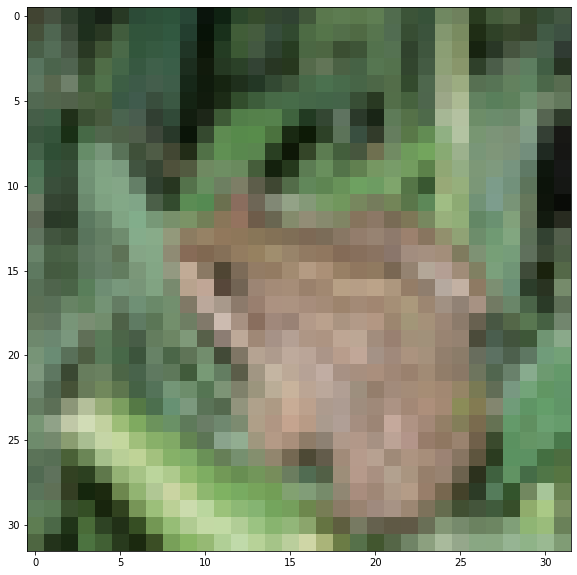

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


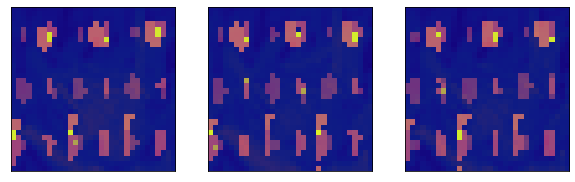

ConvLayer 1:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:222: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


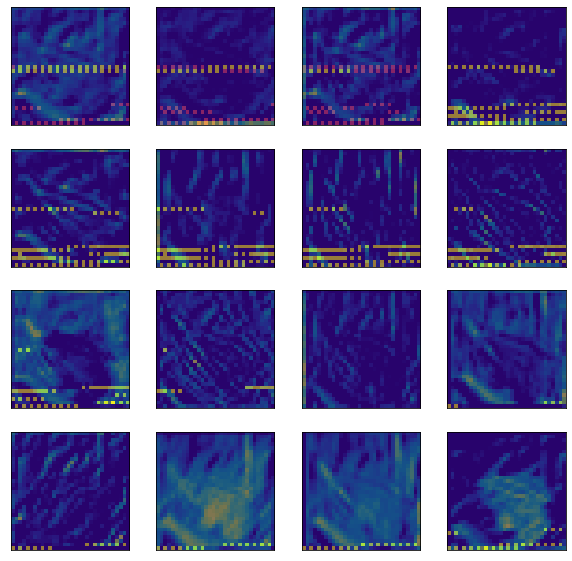

ConvLayer 2:


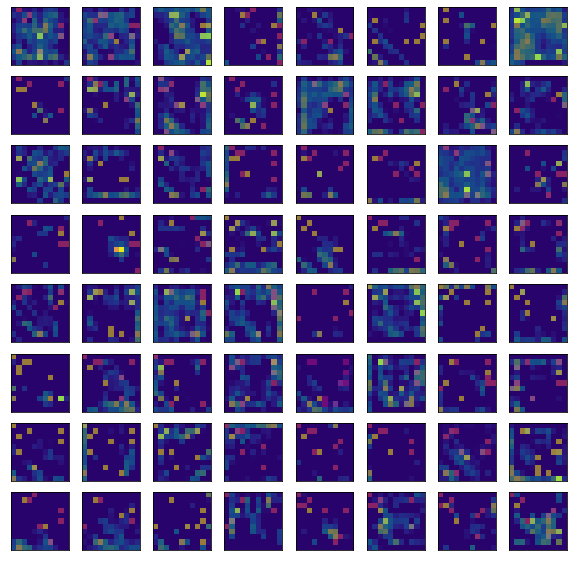

ConvLayer 3:


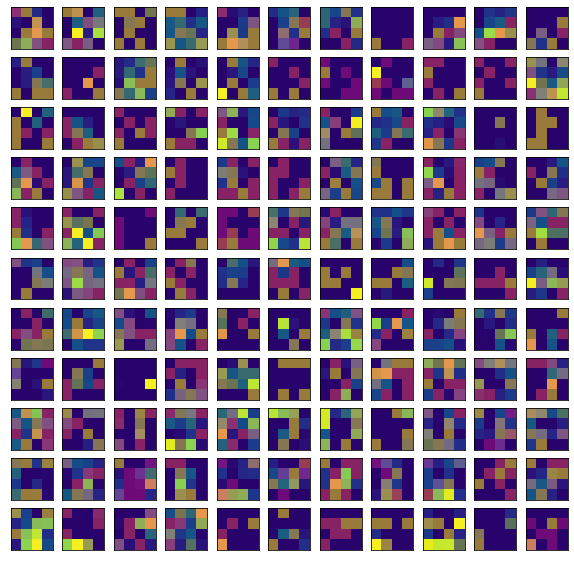

In [216]:
# use the correct classe's pathways
interpretation_index = 4
single_class_vips = class_vips[test_labels[interpretation_index].item()]

plot_pathways(img_index=interpretation_index, pathways=single_class_vips, n_important=2000, plot_featmaps=True, average_pathways=True, use_inputs=True)

The results are not as expected, maybe I have bugs in the code or the analysis method does not work as we thought it would.  
Eventually we will archive this project for now.

# Try with input features only:<a name="try-with-input-features-only"></a>

We can try one more thing. I.e. lay our focus onto the input features.  
The visualisation above showed weird patterns in the feature maps while the masks of the input channels seemed  more reasonable.

## Extract input features:<a name="extract-input-features5"></a>

In [217]:
def get_input_features(img_batch):

    # each layer's number of neurons
    input_features = np.prod(np.shape(img_batch)[1:])  # x-axis indices 0 to 3071       # 3072 elements

    # reshape to shape (instances, neurons), transpose n_channels to first index
    input_l = np.transpose(img_batch, [0, 3, 1, 2])
    input_l = np.reshape(img_batch, (10000, input_features))

    print('Shapes of flattened activations:')
    print('Input: ' + str(np.shape(input_l)))
    print()
    
    input_features = input_l

    print('Instances x Neurons matrix with shape ' + str(np.shape(input_features)))
    
    return input_features

In [218]:
input_features = get_input_features(test_images)

Shapes of flattened activations:
Input: (10000, 3072)

Instances x Neurons matrix with shape (10000, 3072)


## Identify pathways via PCA:<a name="identify-pathways5"></a>

In [219]:
# number of PCA componants resembles number of pathways
pca = PCA(n_components=100)

# activation of each pathway
factor_activation = pca.fit_transform(input_features)
print('Pathway/Factor activations: ' + str(np.shape(factor_activation)))

# weight of each input value or neuron for each pathway
factor_loadings = pca.components_
print('Factor loadings: ' + str(np.shape(factor_loadings)))

print('Explained variance ratio: ' + str(sum(pca.explained_variance_ratio_)))

Pathway/Factor activations: (10000, 100)
Factor loadings: (100, 3072)
Explained variance ratio: 0.9022264643445902


## Task Knowledge:<a name="task-knowledge5"></a>

In [220]:
task_knowledge = np.reshape(test_labels, (len(test_labels),))

print(np.shape(task_knowledge))
print(np.shape(input_features))

(10000,)
(10000, 3072)


In [221]:
linear_model_2 = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000).fit(factor_activation, task_knowledge)

# relative contribution of each pathway
linear_model_2_weights = linear_model_2.coef_

In [222]:
print(np.shape(linear_model_2_weights))

(10, 100)


In [223]:
# specify number of pathways to visualize
n_pathways = 3

# list of very/most important pathways (vip)
class_vips = []

for class_index in range(len(linear_model_2_weights)):
    abs_metric_weights = [abs(i) for i in linear_model_2_weights[class_index,:]]
    class_vips.append(np.argpartition(abs_metric_weights, -n_pathways)[-n_pathways:])

## Plotting:<a name="plotting5"></a>

In [224]:
# plot input channels with pathways:
def plot_avg_input_pathways(img_index, pathways, n_important):
    
    # create mask with same shape as input images: (32, 32, 3)
    input_mask = np.zeros((32, 32, 3))
    
    # plot channels of input image
    for i in range(3):
        inx = plt.subplot(1, 3, i+1)
        inx.set_xticks([])
        inx.set_yticks([])
        plt.imshow(test_images[img_index][:,:,i])
    
    # get important neurons of vips
    for pathway in pathways[test_labels[img_index].item()]:
        neuron_weights = factor_loadings[pathway]
        important_neurons = np.argpartition(neuron_weights, -n_important)[-n_important:]

        for index in important_neurons:
            if index < 3072:
                input_mask[np.unravel_index(index, (32, 32, 3))] += 1/n_important
    
    # plot mask for input channels
    for i in range(3):
        inx = plt.subplot(1, 3, i+1)
        inx.set_xticks([])
        inx.set_yticks([])
        plt.imshow(input_mask[:,:,i], alpha=0.5)
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


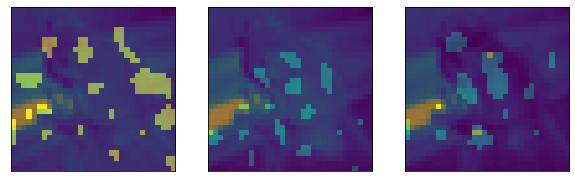

In [225]:
plot_avg_input_pathways(img_index=7, pathways=class_vips, n_important=100)

The results look more reasonable. Maybe this method could be further tested as a input analysis tool.